<a href="https://colab.research.google.com/github/balaksuiuc/CS598IQVIAClaims/blob/main/src/cost_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CS598 Deep Learning for Healthcare**

## **1. Setup**

### 1.1 Change the google colab settings
We can use a GPU on the google colab by setting below.  
**Edit -> Notebook setting -> Hardware accelerator -> GPU**

### 1.2 Check if the GPU is available in the Colab environment

In [1]:
# The code in this cell is inspired by https://mccormickml.com/2019/07/22/BERT-fine-tuning/
import tensorflow as tf

# Get the GPU device name
device_name = tf.test.gpu_device_name()
print('Device name: {}'.format(device_name))

Device name: /device:GPU:0


### 1.3 GPU setting for PyTourch

In [2]:
# The code in this cell is inspired by https://mccormickml.com/2019/07/22/BERT-fine-tuning/
import torch

# Tell PyTorch to use the GPU
device = torch.device("cuda")
print('GPU:', torch.cuda.get_device_name(0))

GPU: Tesla T4


### 1.4 import necessary packages and setup RNG


In [3]:
import os
import pickle
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

# set seed
seed = 100

def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(seed)

## **2. Dataset pre-process and embedding**

### 2.1 Load the IQVIA data from google drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


[Note]
Need to upload the iqvia data to your google drive

In [5]:
DATA_DIR = '/content/drive/MyDrive/iqvia_data/'

In [ ]:
import pandas as pd
ENROLL_FILE = DATA_DIR + 'enroll_synth.dat'
CLAIMS_2019 = DATA_DIR + 'claims_2019.dat'
CLAIMS_2018 = DATA_DIR + 'claims_2018.dat'
CLAIMS_2017 = DATA_DIR + 'claims_2017.dat'
CLAIMS_2016 = DATA_DIR + 'claims_2016.dat'
CLAIMS_2015 = DATA_DIR + 'claims_2015.dat'

df_enroll = pd.read_csv(ENROLL_FILE, sep='|', low_memory=False)

df_claims2019 = pd.read_csv(CLAIMS_2019, sep='|', low_memory=False)
df_claims2018 = pd.read_csv(CLAIMS_2018, sep='|', low_memory=False)
df_claims2017 = pd.read_csv(CLAIMS_2017, sep='|', low_memory=False)
df_claims2016 = pd.read_csv(CLAIMS_2016, sep='|', low_memory=False)
df_claims2015 = pd.read_csv(CLAIMS_2015, sep='|', low_memory=False)

## Add year and create a single dataset for claims
df_claims2015["year"] = 2015
df_claims2016["year"] = 2016
df_claims2017["year"] = 2017
df_claims2018["year"] = 2018
df_claims2019["year"] = 2019

list_of_claims = [df_claims2015, df_claims2016, df_claims2017, df_claims2018, df_claims2019]
df_claims = pd.concat(list_of_claims)

In [ ]:
# enroll data
print("Shape of Claims{}".format(df_enroll.shape))
df_enroll.sample(n=5, random_state=0)

Shape of Claims(30000, 17)


,estring,clm_frst,clm_last,nbr_clm_lines,enr_frst,enr_last,mon_totl,mxce_fst,mxce_lst,der_sex,der_yob,pat_id,pat_region,pat_state,grp_indv_cd,mh_cd,enr_rel
8225,----------------------------------------------...,2006-01-10,2017-12-27,417,2006-01-01,2018-03-31,147,2006-01-01,2018-03-31,F,1943.0,f433AAAAAAAGVWTS,E,NY,U,Y,21
10794,----------------------------------------------...,2006-06-07,2018-03-05,140,2006-01-01,2018-03-31,147,2006-01-01,2018-03-31,M,1964.0,f433AAAAAAAHRYHG,E,NY,U,Y,21
9163,----------------------------------------------...,2007-07-23,2017-03-14,345,2006-01-01,2017-03-31,135,2006-01-01,2017-03-31,F,1960.0,k306AAAAAABKDKXE,NaN,NaN,U,Y,21
26591,----------------------------------------------...,2016-01-01,2016-03-11,28,2016-01-01,2016-12-31,12,2016-01-01,2016-12-31,M,2015.0,a7e3AAAAAAPPAPTW,W,CA,U,N,21
6631,----------------------------------------------...,2017-04-28,2017-05-26,22,2016-03-01,2017-05-31,15,2016-03-01,2017-05-31,F,1995.0,pg20AAAAADXVWYQN,MW,IL,U,N,21


In [ ]:
# claim data
print("Shape of Claims{}".format(df_claims.shape))
df_claims.sample(n=5, random_state=0)

Shape of Claims(2438054, 65)


,pat_id,claimno,linenum,rectype,tos_flag,pos,conf_num,patstat,billtype,ndc,daw,formulary,dayssup,quan,proc_cde,cpt_mod,rev_code,srv_unit,from_dt,to_dt,diagprc_ind,diag_admit,diag1,diag2,diag3,diag4,diag5,diag6,diag7,diag8,diag9,diag10,diag11,diag12,icdprc1,icdprc2,icdprc3,icdprc4,icdprc5,icdprc6,icdprc7,icdprc8,icdprc9,icdprc10,icdprc11,icdprc12,charge,allowed,paid,deductible,copay,coinsamt,cobamt,dispense_fee,bill_spec,rend_spec,prscbr_spec,att_spec,pcp_spec,ref_spec,ptypeflg,sub_tp_cd,pmt_st_cd,paid_dt,year
436407,pf06AAAAAAANBFBA,NaN,1.0,P,0,01,NaN,NaN,NaN,3.78181e+08,NaN,NaN,30.0,15.0,NaN,NaN,NaN,NaN,2015-07-17,2015-07-17,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.22,8.22,6.90,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,U,P,2015-07-22,2015
102630,a7c7AAAAAAMVLNUZ,BM00016399762,1.0,M,1,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99283,NaN,NaN,1.0,2016-10-17,2016-10-17,2,NaN,M79672,M79675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,970.00,970.00,44.60,NaN,NaN,0.0,0.0,NaN,OTHER,OTHER,NaN,NaN,NaN,NaN,0,U,P,2016-11-16,2016
552992,pg03AAAAAAQCOAHC,NaN,1.0,A,0,13,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,250,NaN,2015-05-16,2015-05-16,1,NaN,4659,6869,6929,7862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.70,0.00,0.00,NaN,NaN,0.0,0.0,NaN,HOSPITAL,HOSPITAL,NaN,NaN,NaN,NaN,1,U,P,2015-06-15,2015
141699,9004AAAAAAAIWZJJ,1.93473e+11,1.0,M,1,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99212,NaN,NaN,1.0,2019-11-06,2019-11-06,2,NaN,M47812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,133.00,112.20,102.20,0.0,10.0,0.0,0.0,NaN,OTHR_SPC,OTHR_SPC,NaN,NaN,NaN,NaN,0,U,P,2019-12-06,2019
355175,pg03AAAAAABZBLAE,NaN,4.0,M,1,13,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,450,NaN,2015-11-02,2015-11-02,2,NaN,R55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3027.00,52.91,52.91,NaN,NaN,0.0,0.0,NaN,HOSPITAL,HOSPITAL,NaN,NaN,NaN,NaN,1,U,P,2015-12-02,2015


### 2.2 Analyze the dataset

22138
926


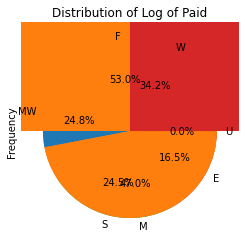

30000
18927
21483
15190
6445
4884


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Distribution of patients across regions
rd = df_enroll["pat_region"].value_counts().plot(kind="pie", autopct="%1.1f%%")
rd.set_title("Distribution of patients across regions")

# Distribution of patients gender
rd = df_enroll["der_sex"].value_counts().plot(kind="pie", autopct="%1.1f%%")
rd.set_title("Distribution of patients' gender")

# Distribution of Age
df_enroll["age"] = 2021 - df_enroll["der_yob"]

rd = df_enroll[df_enroll["der_yob"] > 1900]["age"].plot(kind='hist', bins=15)
rd.set_title("Distribution of patients' age")

# Get the count of claims paid (and denied)
df_claims["pmt_st_cd"].value_counts()

# number of diagnosis populated in each claim
diag_cols = ["diag1", "diag2", "diag3", "diag4", "diag5", "diag6", "diag7", "diag8", "diag9", "diag10", "diag11", "diag12"]
df_claims["num_of_diag"] = df_claims[diag_cols].notnull().sum(axis=1)
df_claims["num_of_diag"].mean()

# number of icdprc populated in each claim
icdprc_cols=["icdprc1", "icdprc2", "icdprc3", "icdprc4", "icdprc5", "icdprc6", "icdprc7", "icdprc8", "icdprc9", "icdprc10", "icdprc11", "icdprc12"]
df_claims["num_of_icdprc"] = df_claims[icdprc_cols].notnull().sum(axis=1)
df_claims["num_of_icdprc"].mean()

diag = []
for colname in diag_cols:
    diag.extend(pd.unique(df_claims[colname]))
print(len(np.unique(diag)))
# 22138

prc = []
for colname in icdprc_cols:
    prc.extend(pd.unique(df_claims[colname]))
print(len(np.unique(prc)))
# 926


# number of claims with same day service
sum(df_claims["from_dt"] == df_claims["to_dt"])
# 2378556 out of 2438054 i.e. 97.5%

# Distribution of charges
rd = df_claims["charge"].plot(kind='hist', bins=15)
rd.set_title("Distribution charges")

# Log charges makes more sense
# filtering out rows where charges are less than 1
rd = np.log10(df_claims[df_claims["charge"] > 1]["charge"]).plot(kind='hist', bins=15)
rd.set_title("Distribution of Log of Charges")

# Distribution of Paid amounts
# filtering out rows where paid are less than 1
rd = np.log10(df_claims[df_claims["paid"] > 1]["paid"]).plot(kind='hist', bins=25)
rd.set_title("Distribution of Log of Paid")
plt.show()


# Checking the unique number of patients in the datasets
print(len(pd.unique(df_enroll['pat_id'])))
# 30000
print(len(pd.unique(df_claims2015['pat_id'])))
# 18927
print(len(pd.unique(df_claims2016['pat_id'])))
#21483
print(len(pd.unique(df_claims2017['pat_id'])))
#15190
print(len(pd.unique(df_claims2018['pat_id'])))
#6445
print(len(pd.unique(df_claims2019['pat_id'])))
#4884

### 2.3 Embedding

0 647.9217659590098 1885
(18474, 2) 3257 55.39920970011909 1


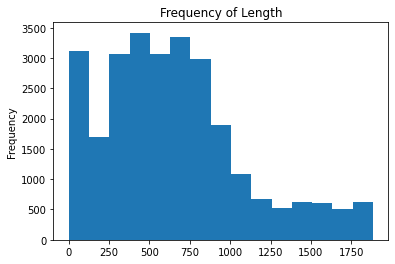

In [ ]:
# Wei's code here
#assign quarter to each record and convert 'to_dt' to datetime format
df_claims["quarter"] = pd.PeriodIndex(pd.to_datetime(df_claims["to_dt"]), freq = 'Q')
df_claims['to_dt'] = pd.to_datetime(df_claims['to_dt'])

#find the length of claims for each patient
df_claims_length = df_claims[['pat_id','to_dt']].groupby('pat_id').agg({'to_dt':['max','min']}).reset_index() 
df_claims_length.columns = ['pat_id','max','min']
df_claims_length['length'] = df_claims_length['max'] - df_claims_length['min']
df_claims_length['length'] = df_claims_length['length'].dt.days
avg_claim_length = df_claims_length['length'].mean()
min_claim_length = df_claims_length['length'].min()
max_claim_length = df_claims_length['length'].max()
print(min_claim_length,avg_claim_length,max_claim_length)
rd = df_claims_length['length'].plot(kind='hist', bins=15)
rd.set_title("Frequency of Length")
#most patients's length is less than three years, 12 quarters, so chooce an observation window of 12 quarters

#calculate index date = last claim - 270 days (180days as prediction window + 90days as last quarter)
claim_indx_date = df_claims[['pat_id','to_dt']].groupby('pat_id').agg({'to_dt':['max']}).reset_index()
claim_indx_date.columns = ['pat_id','max']
claim_indx_date['indx_date'] = claim_indx_date['max'] - pd.to_timedelta(270,unit='d')
#filter claims, 
filterred_claims = pd.merge(df_claims,claim_indx_date,how = 'left',on=['pat_id'])
#observation includes 1000 days(three years) before index date
#prediction window is 180 days (two quarters), last 90 days(last quarter) is reserved as target
filterred_observation = filterred_claims.loc[filterred_claims.to_dt<=filterred_claims.indx_date]
filterred_observation = filterred_observation.loc[filterred_observation.to_dt>=filterred_observation.indx_date-pd.to_timedelta(1095,unit='d')]
filterred_observation = filterred_observation.loc[filterred_observation.to_dt>=pd.to_datetime('2015-10-1')] #code changed after October 1, 2015
filterred_target = filterred_claims.loc[filterred_claims.to_dt>=filterred_claims.indx_date+pd.to_timedelta(180,unit='d')]

#find the number of claims after filter
pat_claimsnumb = filterred_observation[['pat_id']].groupby('pat_id').agg({'pat_id':['count']}).reset_index()
pat_claimsnumb.columns = ['pat_id','count']
print(pat_claimsnumb.shape,pat_claimsnumb['count'].max(),pat_claimsnumb['count'].mean(),pat_claimsnumb['count'].min())

In [ ]:
diag_cols = ["diag1", "diag2", "diag3", "diag4", "diag5", "diag6", "diag7", "diag8", "diag9", "diag10", "diag11", "diag12"]
icdprc_cols=["icdprc1", "icdprc2", "icdprc3", "icdprc4", "icdprc5", "icdprc6", "icdprc7", "icdprc8", "icdprc9", "icdprc10", "icdprc11", "icdprc12"]

#number of unique diag codes and prc codes after filter
diag = []
for colname in diag_cols:
    diag.extend(pd.unique(filterred_observation[colname]))
diag_dict = np.unique(diag)
print(len(np.unique(diag)))

prc = []
for colname in icdprc_cols:
    prc.extend(pd.unique(filterred_observation[colname]))
prc_dict = np.unique(prc)
print(len(np.unique(prc)))

#number of unique record type, procedure code and revenue code(high-level description of services)
filterred_observation["rectype"] = filterred_observation["rectype"].astype('str')
filterred_observation["proc_cde"] = filterred_observation["proc_cde"].astype('str')
filterred_observation["rev_code"] = filterred_observation["rev_code"].astype('str')
print(len(np.unique(filterred_observation["rectype"])))
print(len(np.unique(filterred_observation["proc_cde"])))
print(len(np.unique(filterred_observation["rev_code"])))
rectype_dict = np.unique(filterred_observation["rectype"])
proc_cde_dict = np.unique(filterred_observation["proc_cde"])
rev_code_dict = np.unique(filterred_observation["rev_code"])

#extract interested columns
filtered_features = filterred_observation[["pat_id","paid","charge","quarter","rectype","proc_cde","rev_code","diag1", "diag2", "diag3", 
                                           "diag4", "diag5", "diag6", "diag7", "diag8", "diag9", "diag10", "diag11","diag12","icdprc1", 
                                           "icdprc2", "icdprc3", "icdprc4", "icdprc5", "icdprc6", "icdprc7", "icdprc8", "icdprc9","icdprc10",
                                           "icdprc11", "icdprc12"]]

print(filtered_features.shape)


12952
420
6
6114
718
(1023445, 31)


115 41 105 7


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

(1023445, 9)


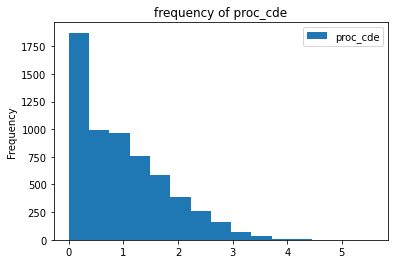

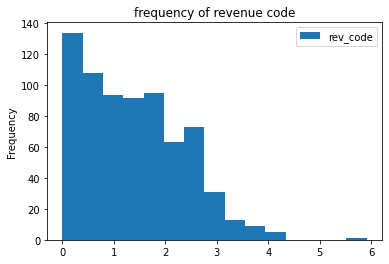

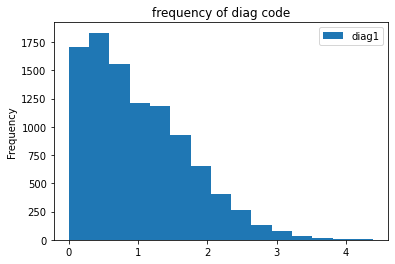

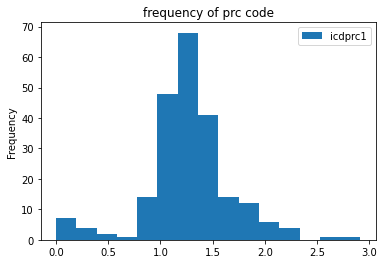

In [ ]:
#investigate unqiue codes after filter
proc_cde_valuecount = filtered_features["proc_cde"].value_counts()
rev_code_valuecount = filtered_features["rev_code"].value_counts()
diag_valuecount = filtered_features["diag1"].value_counts()
prc_valuecount = filtered_features["icdprc1"].value_counts()

proc_cde_valuecount = proc_cde_valuecount.to_frame()
rd = np.log10(proc_cde_valuecount).plot(kind='hist', bins=15)
rd.set_title("frequency of proc_cde")
#among 6114, less than 500 proc codes appear more than 100 times
rev_code_valuecount = rev_code_valuecount.to_frame()
rd = np.log10(rev_code_valuecount).plot(kind='hist', bins=15)
rd.set_title("frequency of revenue code")
#among 718, less than 300 revenue codes appear more than 100 times
diag_valuecount = diag_valuecount.to_frame()
rd = np.log10(diag_valuecount).plot(kind='hist', bins=15)
rd.set_title("frequency of diag code")
#among 12952, about 1000 diag codes appear more than 100 times
prc_valuecount = prc_valuecount.to_frame()
rd = np.log10(prc_valuecount).plot(kind='hist', bins=15)
rd.set_title("frequency of prc code")
#among 420, less than 50 appear more than 100 times

proc_cde_valuecount = filtered_features["proc_cde"].value_counts().reset_index()
rev_code_valuecount = filtered_features["rev_code"].value_counts().reset_index()
diag_valuecount = filtered_features["diag1"].value_counts().reset_index()
prc_valuecount = filtered_features["icdprc1"].value_counts().reset_index()

#apply thresholds on codes to extract dictionary for high frequency codes
proc_cde_dict = set(proc_cde_valuecount.apply(lambda x: x['index'] if x['proc_cde']>=1000 else 0,axis=1).to_list())
rev_code_dict = set(rev_code_valuecount.apply(lambda x: x['index'] if x['rev_code']>=1000 else 0,axis=1).to_list())
diag_dict = set(diag_valuecount.apply(lambda x: x['index'] if x['diag1']>=1000 else 0,axis=1).to_list())
prc_dict = set(prc_valuecount.apply(lambda x: x['index'] if x['icdprc1']>=100 else 0,axis=1).to_list())
proc_cde_dict.remove(0)
rev_code_dict.remove(0)
diag_dict.remove(0)
prc_dict.remove(0)

print(len(proc_cde_dict),len(rev_code_dict),len(diag_dict),len(prc_dict))
#total code features are reduced to less than 300 after filtering

#filter out code features that not appears in the dictionary
def combine_columns_into_list(x,cols,dict_set):
    out = list()
    for col in cols:
        if x[col] in dict_set:
            out.append(x[col])
    return out

filtered_features['diags'] = filtered_features.apply(lambda x: combine_columns_into_list(x,["diag1","diag2","diag3","diag4","diag5","diag6","diag7","diag8","diag9","diag10"],diag_dict),axis=1)
filtered_features['rev_code'] = filtered_features.apply(lambda x: x['rev_code'] if x['rev_code'] in rev_code_dict else 0,axis=1)
filtered_features['icdprc'] = filtered_features.apply(lambda x: x['icdprc1'] if x['icdprc1'] in prc_dict else 0,axis=1)
filtered_features['proc_cde'] = filtered_features.apply(lambda x: x['proc_cde'] if x['proc_cde'] in proc_cde_dict else 0,axis=1)

#drop original code columns
dropped_features = ["diag1", "diag2", "diag3", "diag4", "diag5", "diag6", "diag7", "diag8", "diag9", "diag10", "diag11", 
                "diag12","icdprc1", "icdprc2", "icdprc3", "icdprc4", "icdprc5", "icdprc6", "icdprc7", "icdprc8", "icdprc9",
                "icdprc10", "icdprc11", "icdprc12"]
filtered_features = filtered_features.drop(dropped_features,axis=1)

print(filtered_features.shape)


In [ ]:
filtered_features = filtered_features.drop(['charge'],axis=1)

In [ ]:
#build multi-hot for rectype, proc_cde, rev_code, recvtype and icdprc
filtered_features = pd.get_dummies(filtered_features,columns = ['rectype','proc_cde','rev_code','icdprc'])
print(filtered_features.shape)
filtered_dict_features = filtered_features.copy(deep=True)

#build multi-hot for diags list feature, this code is inspired by https://stackoverflow.com/questions/45312377/how-to-one-hot-encode-from-a-pandas-column-containing-a-list
v = filtered_dict_features.diags.values
l = [len(x) for x in v.tolist()]
f, u = pd.factorize(np.concatenate(v))
n, m = len(v), u.size
i = np.arange(n).repeat(l)

dummies = pd.DataFrame(
    np.bincount(i * m + f, minlength=n * m).reshape(n, m),
    filtered_dict_features.index, u
)

filtered_dict_features = filtered_dict_features.drop('diags', 1).join(dummies)

#filtered_dict_features.to_pickle('./filterd_feature_dict_281.pkl')
filtered_dict_features = filtered_dict_features.groupby(['pat_id','quarter']).sum().reset_index()
#sort the pat_id and quarter in ascending order
filtered_dict_features = filtered_dict_features.sort_values(by=['pat_id','quarter'],ascending=False)

print(filtered_dict_features.shape)


(1023445, 176)
(72814, 280)


In [ ]:
#filtered_dict_features = filtered_dict_features.drop(['charge'],axis = 1)
print(filtered_dict_features.shape)
filtered_dict_features.to_csv('./feature_280.csv', index = False, header=True)

(72814, 280)


In [ ]:
#build pat_id list to extract data from filtered_dict_features
pat_ids_dict = set(np.unique(filtered_dict_features['pat_id']))
pat_ids_dict = sorted(list(pat_ids_dict),reverse=True)


#construct data for model training
x = np.zeros((18474,278*12))


## construct x matrix
num_pat = 0
for pat in pat_ids_dict:
    pat_val = filtered_dict_features.loc[filtered_dict_features['pat_id']==pat]
    pat_val = pat_val.drop(['pat_id','quarter'],axis=1)
    raw_values = pat_val.values.tolist()
    if len(raw_values)>12:
        raw_values = raw_values[:-1] #in case of 13 quarters
    values = [item for sublist in raw_values for item in sublist]
    x[num_pat,:len(values)] = values
    num_pat+=1

#np.savetxt("x_18474_3348.csv", x, delimiter=",")


In [ ]:
#build the y vector
y_paid = filterred_target[['pat_id','paid']].groupby('pat_id').agg({'paid':['sum']}).reset_index() 
y_charge = filterred_target[['pat_id','charge']].groupby('pat_id').agg({'charge':['sum']}).reset_index() 
y_paid.columns = ['pat_id','paid']
y_charge.columns = ['pat_id','charge']
print(y_paid.shape,y_charge.shape)
print(y_paid.isnull().values.any(),y_charge.isnull().values.any())

y_charge['miss'] = y_charge.apply(lambda x: 0 if x['pat_id'] in pat_ids_dict else 1,axis=1)
y_charge = y_charge.loc[y_charge['miss']!=1]
y_charge = y_charge.drop(['miss'],axis=1)
y_charge = y_charge.sort_values(by=['pat_id'],ascending = False)

y_paid['miss'] = y_paid.apply(lambda x: 0 if x['pat_id'] in pat_ids_dict else 1,axis=1)
y_paid = y_paid.loc[y_paid['miss']!=1]
y_paid = y_paid.drop(['miss'],axis=1)
y_paid = y_paid.sort_values(by=['pat_id'],ascending = False)

#patient id is matched row by row between y_paid and x
print(y_charge['pat_id'].to_list()==pat_ids_dict)
print(y_paid['pat_id'].to_list()==pat_ids_dict)
#True True

ypaid = np.array(y_paid['paid'].to_list())
#np.savetxt("ypaid.csv", ypaid, delimiter=",")
ycharge = np.array(y_charge['charge'].to_list())
#np.savetxt("ycharge.csv", ycharge, delimiter=",")


(27226, 2) (27226, 2)
False False
True
True


### 2.4 Reduced Feature Dataset

In [ ]:
# append enroll information
df_enroll = df_enroll.drop(['estring', 'clm_frst', 'clm_last', 'nbr_clm_lines', 'enr_frst',
       'enr_last', 'mon_totl', 'mxce_fst', 'mxce_lst', 'der_sex', 'der_yob', 'pat_state', 'grp_indv_cd', 'mh_cd', 'enr_rel'],axis=1)
df_enroll = df_enroll.replace(np.nan, 'F', regex=True)
# map patient region to patient from enroll to claims
df_claims = pd.merge(df_claims,df_enroll,on=['pat_id'],how='left')

pay_region = df_claims[['paid','pat_region']].groupby('pat_region').agg({'paid':['mean']}).reset_index() 
print(pay_region) #average paid is differ by region

In [ ]:
#assign quarter to each record and convert 'to_dt' to datetime format
df_claims["quarter"] = pd.PeriodIndex(pd.to_datetime(df_claims["to_dt"]), freq = 'Q')
df_claims['to_dt'] = pd.to_datetime(df_claims['to_dt'])

#find the length of claims for each patient
df_claims_length = df_claims[['pat_id','to_dt']].groupby('pat_id').agg({'to_dt':['max','min']}).reset_index() 
df_claims_length.columns = ['pat_id','max','min']
df_claims_length['length'] = df_claims_length['max'] - df_claims_length['min']
df_claims_length['length'] = df_claims_length['length'].dt.days
avg_claim_length = df_claims_length['length'].mean()
min_claim_length = df_claims_length['length'].min()
max_claim_length = df_claims_length['length'].max()
#most patients's length is less than three years, 12 quarters, so chooce an observation window of 6 quarters

#calculate index date = last claim - 270 days (180days as prediction window + 90days as last quarter)
claim_indx_date = df_claims[['pat_id','to_dt']].groupby('pat_id').agg({'to_dt':['max']}).reset_index()
claim_indx_date.columns = ['pat_id','max']
claim_indx_date['indx_date'] = claim_indx_date['max'] - pd.to_timedelta(270,unit='d')
#filter claims, 
filterred_claims = pd.merge(df_claims,claim_indx_date,how = 'left',on=['pat_id'])
#observation includes 1000 days(three years) before index date
#prediction window is 180 days (two quarters), last 90 days(last quarter) is reserved as target
filterred_observation = filterred_claims.loc[filterred_claims.to_dt<=filterred_claims.indx_date]
filterred_observation = filterred_observation.loc[filterred_observation.to_dt>=filterred_observation.indx_date-pd.to_timedelta(548,unit='d')]
filterred_observation = filterred_observation.loc[filterred_observation.to_dt>=pd.to_datetime('2015-10-1')] #code changed after October 1, 2015
filterred_target = filterred_claims.loc[filterred_claims.to_dt>=filterred_claims.indx_date+pd.to_timedelta(180,unit='d')]

filterred_observation["proc_cde"] = filterred_observation["proc_cde"].astype('str')
filterred_observation["icdprc1"] = filterred_observation["icdprc1"].astype('str')
#extract interested columns
filtered_features = filterred_observation[["pat_id","paid","quarter","proc_cde","icdprc1","pat_region"]]
print(filtered_features.shape) #(826906, 6)

proc_cde_valuecount = filtered_features["proc_cde"].value_counts().reset_index()
prc_valuecount = filtered_features["icdprc1"].value_counts().reset_index()
#apply thresholds on codes to extract dictionary for high frequency codes
proc_cde_dict = set(proc_cde_valuecount.apply(lambda x: x['index'] if x['proc_cde']>=1000 else 0,axis=1).to_list())
prc_dict = set(prc_valuecount.apply(lambda x: x['index'] if x['icdprc1']>=100 else 0,axis=1).to_list())
proc_cde_dict.remove(0)
prc_dict.remove(0)

filtered_features['icdprc'] = filtered_features.apply(lambda x: x['icdprc1'] if x['icdprc1'] in prc_dict else 0,axis=1)
filtered_features['proc_cde'] = filtered_features.apply(lambda x: x['proc_cde'] if x['proc_cde'] in proc_cde_dict else 0,axis=1)
#build multi-hot for rectype, proc_cde, rev_code, recvtype and icdprc
filtered_features = pd.get_dummies(filtered_features,columns = ['proc_cde','icdprc','pat_region'])
filtered_dict_features = filtered_features.copy(deep=True)
filtered_dict_features= filtered_dict_features.drop(['icdprc1'],axis=1)
print(filtered_dict_features.shape)

#filtered_dict_features.to_pickle('./filterd_feature_dict_281.pkl')
filtered_dict_features = filtered_dict_features.groupby(['pat_id','quarter']).sum().reset_index()
#sort the pat_id and quarter in ascending order
filtered_dict_features = filtered_dict_features.sort_values(by=['pat_id','quarter'],ascending=False)

#build pat_id list to extract data from filtered_dict_features
pat_ids_dict = set(np.unique(filtered_dict_features['pat_id']))
pat_ids_dict = sorted(list(pat_ids_dict),reverse=True)
print(len(pat_ids_dict))

#maximum quarters of all patients, will truncate to 12
maxnum_quarters = 0
for pat in pat_ids_dict:
    x = filtered_dict_features.loc[filtered_dict_features['pat_id']==pat]
    maxnum_quarters = max(maxnum_quarters,x.shape[0])
print(maxnum_quarters) #7

#construct data for model training
x = np.zeros((18312,101*6))
## construct x matrix
num_pat = 0
for pat in pat_ids_dict:
    pat_val = filtered_dict_features.loc[filtered_dict_features['pat_id']==pat]
    pat_val = pat_val.drop(['pat_id','quarter'],axis=1)
    raw_values = pat_val.values.tolist()
    if len(raw_values)>6:
        raw_values = raw_values[:-1]
    values = [item for sublist in raw_values for item in sublist]
    x[num_pat,:len(values)] = values
    num_pat+=1

In [ ]:
#build the y vector
y_paid = filterred_target[['pat_id','paid']].groupby('pat_id').agg({'paid':['sum']}).reset_index() 
y_charge = filterred_target[['pat_id','charge']].groupby('pat_id').agg({'charge':['sum']}).reset_index() 
y_paid.columns = ['pat_id','paid']
y_charge.columns = ['pat_id','charge']
print(y_paid.shape,y_charge.shape)
print(y_paid.isnull().values.any(),y_charge.isnull().values.any())

y_charge['miss'] = y_charge.apply(lambda x: 0 if x['pat_id'] in pat_ids_dict else 1,axis=1)
y_charge = y_charge.loc[y_charge['miss']!=1]
y_charge = y_charge.drop(['miss'],axis=1)
y_charge = y_charge.sort_values(by=['pat_id'],ascending = False)

y_paid['miss'] = y_paid.apply(lambda x: 0 if x['pat_id'] in pat_ids_dict else 1,axis=1)
y_paid = y_paid.loc[y_paid['miss']!=1]
y_paid = y_paid.drop(['miss'],axis=1)
y_paid = y_paid.sort_values(by=['pat_id'],ascending = False)

#patient id is matched row by row between y_paid and x
print(y_charge['pat_id'].to_list()==pat_ids_dict)
print(y_paid['pat_id'].to_list()==pat_ids_dict)
#True True

ypaid = np.array(y_paid['paid'].to_list())
#np.savetxt("ypaid.csv", ypaid, delimiter=",")
ycharge = np.array(y_charge['charge'].to_list())
#np.savetxt("ycharge.csv", ycharge, delimiter=",")

In [ ]:
# Load csv data that is already preprocessed by Wei
# -> Wei's code should be in this ipynb?

## **3. Dataset loading/normalization/split**

### 3.2 Load prepared data

In [6]:
#
def read_emb_csv(filepath):
    #pd_x = pd.read_csv(filepath + 'x_18474_3348.csv')
    #pd_x = pd.read_csv(filepath + 'x_18474_3336.csv')
    pd_y_charge = pd.read_csv(filepath + 'ycharge.csv')
    pd_y_paid = pd.read_csv(filepath + 'ypaid.csv')

    pd_x = pd.read_csv(filepath + 'x_18312_606.csv')
    pd_y_paid = pd.read_csv(filepath + 'ypaid_18312.csv')
    return pd_x, pd_y_charge, pd_y_paid

# load the emb csv
EMB_DATA_PATH = '/content/drive/MyDrive/iqvia_data/'
pd_x, pd_y_charge, pd_y_paid = read_emb_csv(EMB_DATA_PATH) 
    

In [7]:
print("pd_x: {}".format(pd_x.shape))
print("pd_y_charge: {}".format(pd_y_charge.shape))
print("pd_y_paid: {}".format(pd_y_paid.shape))

pd_x: (18311, 606)
pd_y_charge: (18473, 1)
pd_y_paid: (18311, 1)


In [ ]:
pd_y_paid.describe()

,5.061299999999999955e+02
count,1.847300e+04
mean,1.810990e+03
std,1.460997e+04
min,0.000000e+00
25%,9.391000e+01
50%,3.042600e+02
75%,9.233300e+02
max,1.552063e+06


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f890b427e90>]],
      dtype=object)

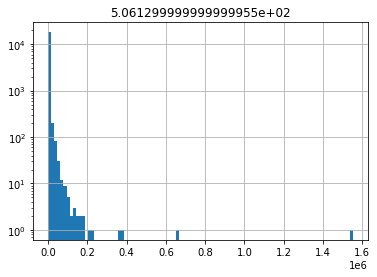

In [ ]:
pd_y_paid.hist(bins=100, log=True)

In [8]:
outlier = np.where(pd_y_paid > 100000)[0]
print(outlier)
print(outlier.shape)
#print(pd_y_paid.loc[np.where(pd_y_paid > 100000)[0]])

[  194   442  1076  1343  1696  2909  3278  3853  4032  4473  5777  6600
  6767  6839  8166 11376 12221 12363 13057 16598]
(20,)


In [9]:
# Drop outlier
pd_x = pd_x.drop(index=outlier)
pd_y_paid = pd_y_paid.drop(index=outlier)

In [ ]:
pd_x.describe()

,3.487200000000000273e+02,0.000000000000000000e+00,0.000000000000000000e+00.1,0.000000000000000000e+00.2,8.000000000000000000e+00,0.000000000000000000e+00.3,1.000000000000000000e+01,0.000000000000000000e+00.4,0.000000000000000000e+00.5,0.000000000000000000e+00.6,0.000000000000000000e+00.7,0.000000000000000000e+00.8,0.000000000000000000e+00.9,0.000000000000000000e+00.10,0.000000000000000000e+00.11,0.000000000000000000e+00.12,0.000000000000000000e+00.13,0.000000000000000000e+00.14,0.000000000000000000e+00.15,0.000000000000000000e+00.16,0.000000000000000000e+00.17,0.000000000000000000e+00.18,0.000000000000000000e+00.19,0.000000000000000000e+00.20,0.000000000000000000e+00.21,0.000000000000000000e+00.22,0.000000000000000000e+00.23,0.000000000000000000e+00.24,0.000000000000000000e+00.25,0.000000000000000000e+00.26,0.000000000000000000e+00.27,0.000000000000000000e+00.28,0.000000000000000000e+00.29,0.000000000000000000e+00.30,0.000000000000000000e+00.31,0.000000000000000000e+00.32,0.000000000000000000e+00.33,0.000000000000000000e+00.34,0.000000000000000000e+00.35,0.000000000000000000e+00.36,...,0.000000000000000000e+00.3245,0.000000000000000000e+00.3246,0.000000000000000000e+00.3247,0.000000000000000000e+00.3248,0.000000000000000000e+00.3249,0.000000000000000000e+00.3250,0.000000000000000000e+00.3251,0.000000000000000000e+00.3252,0.000000000000000000e+00.3253,0.000000000000000000e+00.3254,0.000000000000000000e+00.3255,0.000000000000000000e+00.3256,0.000000000000000000e+00.3257,0.000000000000000000e+00.3258,0.000000000000000000e+00.3259,0.000000000000000000e+00.3260,0.000000000000000000e+00.3261,0.000000000000000000e+00.3262,0.000000000000000000e+00.3263,0.000000000000000000e+00.3264,0.000000000000000000e+00.3265,0.000000000000000000e+00.3266,0.000000000000000000e+00.3267,0.000000000000000000e+00.3268,0.000000000000000000e+00.3269,0.000000000000000000e+00.3270,0.000000000000000000e+00.3271,0.000000000000000000e+00.3272,0.000000000000000000e+00.3273,0.000000000000000000e+00.3274,0.000000000000000000e+00.3275,0.000000000000000000e+00.3276,0.000000000000000000e+00.3277,0.000000000000000000e+00.3278,0.000000000000000000e+00.3279,0.000000000000000000e+00.3280,0.000000000000000000e+00.3281,0.000000000000000000e+00.3282,0.000000000000000000e+00.3283,0.000000000000000000e+00.3284
count,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,...,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.0,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.000000,18453.0,18453.0
mean,927.337872,4.541104,0.023248,2.297187,2.903593,0.224137,0.162846,2.782800,0.149786,0.011543,0.015119,0.032786,0.015770,0.012031,0.011001,0.016366,0.037772,0.027584,0.098304,0.088603,0.012302,0.043841,0.024657,0.032786,0.024386,0.011272,0.031648,0.007858,0.011922,0.014686,0.010730,0.060370,0.011380,0.013602,0.012031,0.012898,0.023628,0.051428,0.009755,0.015661,...,0.005257,0.001734,0.000542,0.002222,0.003143,0.002113,0.003577,0.000542,0.006503,0.003089,0.002005,0.005419,0.004064,0.001843,0.002059,0.002222,0.001734,0.005907,0.0,0.001138,0.000054,0.003577,0.000704,0.002059,0.000813,0.000325,0.005311,0.004064,0.001138,0.001734,0.009809,0.003685,0.00010

In [ ]:
pd_y_paid.describe()

,5.061299999999999955e+02
count,18453.000000
mean,1525.336082
std,5090.648841
min,0.000000
25%,93.660000
50%,303.660000
75%,918.120000
max,97888.740000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8929d28450>]],
      dtype=object)

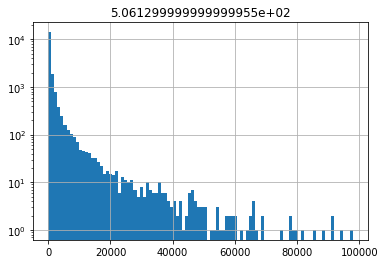

In [ ]:
pd_y_paid.hist(bins=100, log=True)

### 3.3 X variable normalization

In [10]:
# Input data normalization
# https://betashort-lab.com/%E3%83%87%E3%83%BC%E3%82%BF%E3%82%B5%E3%82%A4%E3%82%A8%E3%83%B3%E3%82%B9/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92/%E3%83%87%E3%83%BC%E3%82%BF%E3%81%AE%E6%AD%A3%E8%A6%8F%E5%8C%96%E3%83%87%E3%83%BC%E3%82%BF%E3%81%AE%E5%89%8D%E5%87%A6%E7%90%86/#toc4

from sklearn.preprocessing import MinMaxScaler

if 1:
    scaler_mm = MinMaxScaler()
    scaler_mm.fit(pd_x)
    pd_x = pd.DataFrame(scaler_mm.transform(pd_x))

In [11]:
# https://www.coursera.org/learn/cs598-deep-learning-for-healthcare/programming/eJFr3/homework-3-seq2seq/lab
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, x, y):
        # convert to torch.tensor
        self.x = torch.tensor(x.values.astype(np.float32))
        self.y = torch.tensor(y.values.astype(np.float32))
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        #return self.x.loc[index][:], self.y.loc[index]
        return self.x[index][:], self.y[index]

In [12]:
dataset = CustomDataset(pd_x, pd_y_paid)
print(len(dataset))
#print(dataset[0][0])
#print(dataset[0][0].shape)
#print(dataset[0][1].shape)

18291


### 3.4 Data split

In [13]:
# https://stackoverflow.com/questions/61811946/train-valid-test-split-for-custom-dataset-using-pytorch-and-torchvision
# https://www.coursera.org/learn/cs598-deep-learning-for-healthcare/programming/eJFr3/homework-3-seq2seq/lab

from torch.utils.data.dataset import random_split

train_len = int(len(dataset)*0.7)
val_len = int(len(dataset)*0.2)
lengths = [train_len, val_len, len(dataset) - train_len - val_len]
train_dataset, val_dataset, test_dataset = random_split(dataset, lengths)

print("train data length: {}".format(len(train_dataset)))
print("val data length: {}".format(len(val_dataset)))
print("test data length: {}".format(len(test_dataset)))

train data length: 12803
val data length: 3658
test data length: 1830


### 3.5 Dataloader

In [14]:
# https://www.coursera.org/learn/cs598-deep-learning-for-healthcare/programming/eJFr3/homework-3-seq2seq/lab
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
# Test
# https://www.coursera.org/learn/cs598-deep-learning-for-healthcare/programming/UEdCb/homework-2-neural-networks/lab

train_iter = iter(train_loader)
x, y = next(train_iter)

print('Shape of a batch x:', x.shape)
print('Shape of a batch y:', y.shape)

Shape of a batch x: torch.Size([32, 606])
Shape of a batch y: torch.Size([32, 1])


## **4. Model building**

### **4.1 Random Forest and Gradient Boosting**

In [ ]:
## Random forest - train on "train_dataset", and test on "test_dataset"
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import numpy
train_x = train_dataset.dataset.x
train_y = train_dataset.dataset.y.ravel().cpu().detach().numpy()
test_x  = test_dataset.dataset.x
test_y  = test_dataset.dataset.y.ravel().cpu().detach().numpy()
# filter out rows with Y>100k
tf = train_y <= 100e3
train_x = train_x[tf, :]
train_y = train_y[tf]
tf = test_y <= 100e3
test_x = test_x[tf, :]
test_y = test_y[tf]

# fit random forest
rf = RandomForestRegressor(max_depth=20, random_state=0)
rf.fit(train_x, train_y)
f = rf.predict(test_x)
f[f < 0] = 0
abserr = numpy.abs(f - test_y)
rf_mae = numpy.mean(abserr)
rf_medae = numpy.median(abserr)
print(f"Mean abs err (Random Forest): {rf_mae}")
print(f"Median abs err (Random Forest): {rf_medae}")

## Gradient Boost
gb = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, subsample=0.5)
gb.fit(train_x, train_y)
f = gb.predict(test_x)
f[f < 0] = 0
abserr = numpy.abs(f - test_y)
gb_mae = numpy.mean(abserr)
gb_medae = numpy.median(abserr)
print(f"Mean abs err (Gradient Boost): {gb_mae}")
print(f"Median abs err (Gradient Boost): {gb_medae}")


Mean abs err (Random Forest): 1260.6284445604915
Median abs err (Random Forest): 671.5205644080352


KeyboardInterrupt: ignored

In [ ]:
## errors using median training values as forecast
abserr = numpy.abs(test_y - numpy.median(train_y))
med_mae = numpy.mean(abserr)
med_medae = numpy.median(abserr)
print(f"Mean abs err (median training): {med_mae}")
print(f"Median abs err (median training): {med_medae}")

## errors using mean training values as forecast
abserr = numpy.abs(test_y - numpy.mean(train_y))
med_mae = numpy.mean(abserr)
med_medae = numpy.median(abserr)
print(f"Mean abs err (mean training): {med_mae}")
print(f"Median abs err (mean training): {med_medae}")


### **4.2 Base model(Drewe-Boss’s paper)**

In [23]:
# The purpose of this model is to reproduce the prior model proposed by Drewe-Boss et al.  Deep learning for prediction of population health costs

# This code is inspired by 
#  (1) https://www.coursera.org/learn/cs598-deep-learning-for-healthcare/programming/UEdCb/homework-2-neural-networks/lab
#  (2) https://www.coursera.org/learn/cs598-deep-learning-for-healthcare/programming/VNfPA/homework-4-mina/lab

import torch
import torch.nn as nn
import torch.nn.functional as F

class Db_model(nn.Module):
    def __init__(self, input_size=606, output_size=1):
        super(Db_model, self).__init__()
        self.input_size = input_size
        self.hidden_size = 50
        self.output_size = output_size

        self.fc1 = torch.nn.Linear(in_features=self.input_size, out_features=self.hidden_size)
        self.fc2 = torch.nn.Linear(in_features=self.hidden_size, out_features=self.hidden_size)
        self.fc3 = torch.nn.Linear(in_features=self.hidden_size, out_features=self.hidden_size)
        self.fc4 = torch.nn.Linear(in_features=self.hidden_size+self.input_size, out_features=self.output_size)
        self.do = nn.Dropout(0.25)

    def forward(self, x):
        x0 = x
        x = self.do(F.relu(self.fc1(x)))
        x = self.do(F.relu(self.fc2(x)))
        x = self.do(F.relu(self.fc3(x)))
        x = torch.cat((x, x0), dim=1)
        x = self.do(F.relu(self.fc4(x)))
        
        return x

print(Db_model())

Db_model(
  (fc1): Linear(in_features=606, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=50, bias=True)
  (fc4): Linear(in_features=656, out_features=1, bias=True)
  (do): Dropout(p=0.25, inplace=False)
)


### **4.3 Bala's model**

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class New_model(nn.Module):
    def __init__(self, input_size=606, output_size=1):
        super(New_model, self).__init__()
        self.input_size = input_size
        self.hidden_size = 50
        self.output_size = output_size

        self.fc1 = torch.nn.Linear(in_features=self.input_size, out_features=self.hidden_size)
        self.fc2 = torch.nn.Linear(in_features=self.hidden_size, out_features=self.hidden_size)
        self.fc3 = torch.nn.Linear(in_features=self.hidden_size, out_features=self.hidden_size)
        self.fc4 = torch.nn.Linear(in_features=self.hidden_size+self.input_size, out_features=self.output_size)
        self.do = nn.Dropout(0.5)

    def forward(self, x):
        x0 = x
        '''
        x = self.do(F.relu(self.fc1(x)))
        x = self.do(F.relu(self.fc2(x)))
        x = self.do(F.relu(self.fc3(x)))
        '''
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        #print(x.shape)
        #print(x0.shape)
        x = torch.cat((x, x0), dim=1)
        #print(x.shape)
        x = self.do(F.relu(self.fc4(x)))
        
        return x

model = New_model()
print(model)

New_model(
  (fc1): Linear(in_features=606, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=50, bias=True)
  (fc4): Linear(in_features=656, out_features=1, bias=True)
  (do): Dropout(p=0.5, inplace=False)
)


### **4.4 Advanced model(Base model + alpha)**

In [25]:
class Adv_model(nn.Module):
    def __init__(self, input_size=606, output_size=1):
        super(Adv_model, self).__init__()
        self.input_size = input_size
        self.hidden_size = 50
        self.output_size = output_size

        self.fc1 = torch.nn.Linear(in_features=self.input_size, out_features=self.hidden_size)
        self.fc2 = torch.nn.Linear(in_features=self.hidden_size, out_features=self.hidden_size)
        self.fc3 = torch.nn.Linear(in_features=self.hidden_size, out_features=self.hidden_size)
        #self.fc4 = torch.nn.Linear(in_features=self.hidden_size+self.input_size, out_features=self.output_size)
        self.fc4 = torch.nn.Linear(in_features=self.hidden_size, out_features=self.output_size)
        self.do = nn.Dropout(0.25)

    def forward(self, x):
        x0 = x
        x = self.do(F.relu(self.fc1(x)))
        x = self.do(F.relu(self.fc2(x)))
        x = self.do(F.relu(self.fc3(x)))
        #x = torch.cat((x, x0), dim=1)
        x = self.do(F.relu(self.fc4(x)))
        
        return x

print(Adv_model())

Adv_model(
  (fc1): Linear(in_features=606, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=1, bias=True)
  (do): Dropout(p=0.25, inplace=False)
)


### **4.4 Model Selection**

In [61]:
# Select which model to use

model = Db_model()
#model = New_model()
#model = Adv_model()
print(model)

Db_model(
  (fc1): Linear(in_features=606, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=50, bias=True)
  (fc4): Linear(in_features=656, out_features=1, bias=True)
  (do): Dropout(p=0.25, inplace=False)
)


## **5. Model training**

### 5.1 Loss and optimizer

In [62]:
import torch.nn as nn

# https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html

criterion = nn.MSELoss()
#criterion = nn.L1Loss()

# Learning rate is not written in the prior papar. => Experimental value
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

### 5.2 Evaluation

In [63]:
# https://www.coursera.org/learn/cs598-deep-learning-for-healthcare/programming/UEdCb/homework-2-neural-networks/lab
# https://scikit-learn.org/stable/modules/model_evaluation.html

from sklearn.metrics import *

def regression_metrics(Y_pred, Y_True):
    # Evaluation of methods: 
    # 1. Pearson's correlation (r), 
    # 2. Spearman's correlation (),
    # 3. Mean absolute prediction error (MAPE),
    # 4. R squared (r2),
    # 5. Cumming's Prediction Measure (CPM)
    mae, r2 = mean_absolute_error(Y_True, Y_pred), \
                r2_score(Y_True, Y_pred)

    return mae, r2

def evaluate(model, val_loader):
    model.eval()
    all_y_true = torch.LongTensor()
    all_y_pred = torch.LongTensor()

    val_loss = 0
    for x, y in val_loader:
        y_pred = model(x)

        # convert shape from [batch size, 1] to [batch size]
        y_pred = y_pred.view(y_pred.shape[0])
        y = y.view(y.shape[0])
        
        all_y_true = torch.cat((all_y_true, y.to('cpu').long()), dim=0)
        all_y_pred = torch.cat((all_y_pred, y_pred.to('cpu').long()), dim=0)
        
        loss = criterion(y_pred, y)
        val_loss += loss.item()
    val_loss = val_loss / len(val_loader)
    mae, r2 = regression_metrics(all_y_pred, all_y_true)
    #print(f"mape: {mape:.3f}, r2: {r2:.3f}")
    return val_loss, mae, r2

In [64]:
# test without training
evaluate(model, train_loader)

(28181945.338431265, 1532.9062719675076, -0.09075218736505808)

### 5.3 Training

In [67]:
# https://www.coursera.org/learn/cs598-deep-learning-for-healthcare/programming/eJFr3/homework-3-seq2seq/lab

def train(model, train_loader, val_loader, n_epochs):
    model.train()

    for epoch in range(n_epochs):
        train_loss= 0
        all_y_true = torch.LongTensor()
        all_y_pred = torch.LongTensor()

        for x, y in train_loader:
            optimizer.zero_grad()
            y_pred = model(x)

            #print(y_pred.shape)

            # convert shape from [batch size, 1] to [batch size]
            y_pred = y_pred.view(y_pred.shape[0])
            y_pred[y_pred < 0] = 0

            y = y.view(y.shape[0])
            #print(y_pred.shape)
            #print(y.shape)
            all_y_true = torch.cat((all_y_true, y.to('cpu').long()), dim=0)
            all_y_pred = torch.cat((all_y_pred, y_pred.to('cpu').long()), dim=0)

            loss = criterion(y_pred, y)
            # l1 and l2 implement code is inspired by https://stackoverflow.com/questions/42704283/adding-l1-l2-regularization-in-pytorch
            l_lambda = 0.01
            #l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l_lambda * l2_norm

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss = train_loss / len(train_loader)
        #train_MAE = mean_absolute_error(all_y_true, all_y_pred)
        _, train_MAE, _ = evaluate(model, train_loader)
        val_loss, val_MAE, r2 = evaluate(model, val_loader)
        print('Epoch: {} \t Training Loss: {:.6f} \t Training MAE: {:.6f} \t Validation Loss: {:.6f} \t Validation MAE: {:.6f}'.format(epoch+1, train_loss, train_MAE, val_loss, val_MAE))


In [68]:
n_epochs = 100 # the prior paper's n_epochs=25
train(model, train_loader, val_loader, n_epochs)


Epoch: 1 	 Training Loss: 25539720.877737 	 Training MAE: 1576.954620 	 Validation Loss: 23960680.789130 	 Validation MAE: 1569.108529
Epoch: 2 	 Training Loss: 23391249.162095 	 Training MAE: 1739.806217 	 Validation Loss: 23735569.397826 	 Validation MAE: 1764.025424
Epoch: 3 	 Training Loss: 22378953.611752 	 Training MAE: 1644.647661 	 Validation Loss: 24470155.341304 	 Validation MAE: 1708.269820
Epoch: 4 	 Training Loss: 21641881.748597 	 Training MAE: 1715.410763 	 Validation Loss: 23507348.072826 	 Validation MAE: 1811.413341
Epoch: 5 	 Training Loss: 20536012.016365 	 Training MAE: 1914.003593 	 Validation Loss: 23229878.026087 	 Validation MAE: 2041.863313
Epoch: 6 	 Training Loss: 19765829.516132 	 Training MAE: 1505.529641 	 Validation Loss: 21909491.913043 	 Validation MAE: 1623.910880
Epoch: 7 	 Training Loss: 19019201.773847 	 Training MAE: 1501.058971 	 Validation Loss: 21749162.951087 	 Validation MAE: 1681.548114
Epoch: 8 	 Training Loss: 18308226.427057 	 Training MA

### 6. **Test**

In [69]:
_, test_mae, _ = evaluate(model, test_loader)
print('Test MAE: %.2f'%(test_mae))

Test MAE: 2279.85


## 7. **Visualization**

In [ ]:
## get the model prediction and actual values
import matplotlib.pylab as plt
import pandas

def plot_prediction(model, data_loader, dataset_name='data set'):
    outpred, outact = [], []
    for xx, yy in data_loader:
        ypred = model(xx)
        outpred.extend(ypred.cpu().detach().numpy())
        outact.extend(yy.cpu().detach().numpy())

    outpred = numpy.concatenate(outpred)
    outact  = numpy.concatenate(outact)

    df = pandas.DataFrame({'actual':outact, 'predict':outpred})
    df = df.sort_values('actual')
    print(df.corr())
    plt.plot(df.actual, df.predict, 'r.')
    plt.plot(df.actual, df.actual, 'k-')
    plt.xlabel('actual paid in USD ({})'.format(dataset_name))
    plt.ylabel('predicted paid in USD ({})'.format(dataset_name))

    df['ABSERROR'] = numpy.abs(df.actual - df.predict)
    print(df.ABSERROR.mean(), df.ABSERROR.median())

### **7.1 Training dataset**

           actual   predict
actual   1.000000  0.985154
predict  0.985154  1.000000
246.1818084716797 105.22344970703125


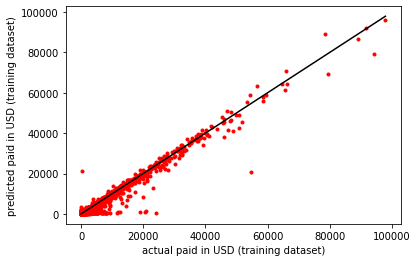

In [ ]:
plot_prediction(model, train_loader, 'training dataset')

### **7.2 Validation dataset**

           actual   predict
actual   1.000000  0.213623
predict  0.213623  1.000000
2313.652099609375 500.54681396484375


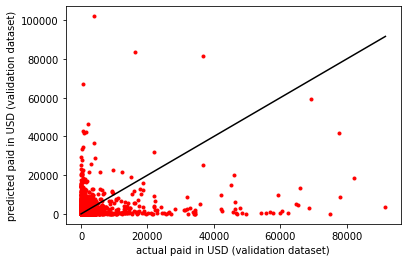

In [ ]:
plot_prediction(model, val_loader, 'validation dataset')

### **7.3 Test dataset**

           actual   predict
actual   1.000000  0.125711
predict  0.125711  1.000000
2139.839599609375 463.5362243652344


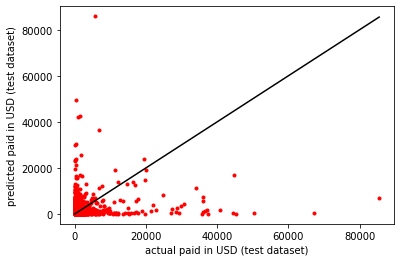

In [ ]:
plot_prediction(model, test_loader, 'test dataset')